<a href="https://colab.research.google.com/github/Zerocrossing/kerithmos/blob/master/Kerithmos_Submission_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $Kerithmos$
Identifying numbers using keras
***

## Background
Here are a few useful papers
* http://proceedings.mlr.press/v28/wan13.pdf
* https://arxiv.org/pdf/1207.0580.pdf
* https://arxiv.org/pdf/1301.3557.pdf
* [Inception Net V2](https://arxiv.org/pdf/1512.00567.pdf)

## Setup
Here we do all our imports, as well as define any constants we use throughout the notebook.

In [0]:
# from tensorflow.keras import 
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
import tensorflow.keras as kr
import requests, zipfile, io, os
import urllib.request
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
print(tf.__version__)

1.13.1


In [0]:
# consts
DATA_DIR = "../data/"
IMG_DIMS = (32,32,3)
NUM_CLASSES = 10
DOWNLOAD_DATA = True # will download datasets directly from source. Useful if running on colab
TRAIN_URL = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
TEST_URL = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
USE_TPU = True


In [0]:
# scale params
SCALE = True
GRAYSCALE = True
FEATUREWISE_CENTER = False
FEATUREWISE_STD_NORMALIZE = False
STANDARDIZE = True

## Load Data
Now we load the sample data from files and rearrange into appropriate format. Keras expects images in the form (samples,channels,x,y) or (samples,x,y,channels). Given the data is stored (x,y,channels,samples) we will use np.moveaxis to change it to a more conventional (and plotable) format.

In [0]:
kr.backend.set_image_data_format('channels_last') #this should be default, but just in case
if DOWNLOAD_DATA:
  urllib.request.urlretrieve(TRAIN_URL, './train.mat')
  urllib.request.urlretrieve(TEST_URL, './test.mat')
  train_data = loadmat("./train.mat")
  test_data = loadmat("./test.mat")
else:
  train_data = loadmat(DATA_DIR + "train.mat")
  test_data = loadmat(DATA_DIR + "test.mat")
X = train_data["X"]
X = np.moveaxis(X, -1, 0)
y = train_data["y"].flatten()-1 # matlab starts arrays at 1
X_test = test_data["X"]
X_test = np.moveaxis(X_test, -1, 0)
y_test = test_data["y"].flatten()-1 # matlab starts arrays at 1
print(X_test.shape)
X.shape #sanity check

(26032, 32, 32, 3)


(73257, 32, 32, 3)

Plot a random selection and it's corresponding label:

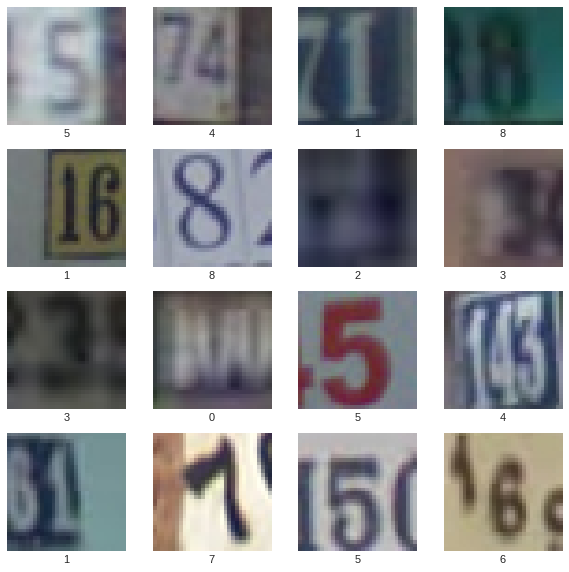

In [0]:
plt.figure(figsize=(10,10))
for i in range(16):
    rnd = np.random.randint(0,X.shape[0])
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[rnd])
    plt.xlabel((y[rnd]+1)%10) #data treats 10 as 0
plt.show()

## Preprocess Data
Firstly we will scale data to $[0,1]$ and convert the image to grayscale, where applicable. The grayscale values were found online, but are mostly consistent with [grayscaling](https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale)

In [0]:
if SCALE:
    X = X / 255.0
    X_test = X_test / 255.0

In [0]:
if GRAYSCALE:
    X = np.dot(X[...,:3], [0.299, 0.587, 0.114])
    X_test = np.dot(X_test[...,:3], [0.299, 0.587, 0.114])
    X = X.reshape(-1,32,32,1)
    X_test = X_test.reshape(-1,32,32,1)
    IMG_DIMS = (32,32,1)

We have the option of using a keras generator to augment images in batches. The datagen needs to be fit to the dataset for it to be able to compute normalizations. Note that using the datagen slows down training by an order of magnitude

In [0]:
datagen = kr.preprocessing.image.ImageDataGenerator(
    featurewise_center=FEATUREWISE_CENTER,
    featurewise_std_normalization=FEATUREWISE_STD_NORMALIZE,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=False) #not kosher for numbers
datagen.fit(X)

Even if we don't want to use the datagen to augment samples during training, we can use it now to standardize the entire dataset.

In [0]:
if STANDARDIZE:
    X = datagen.standardize(X)
    X_test = datagen.standardize(X_test)

Show result of image preprocessing

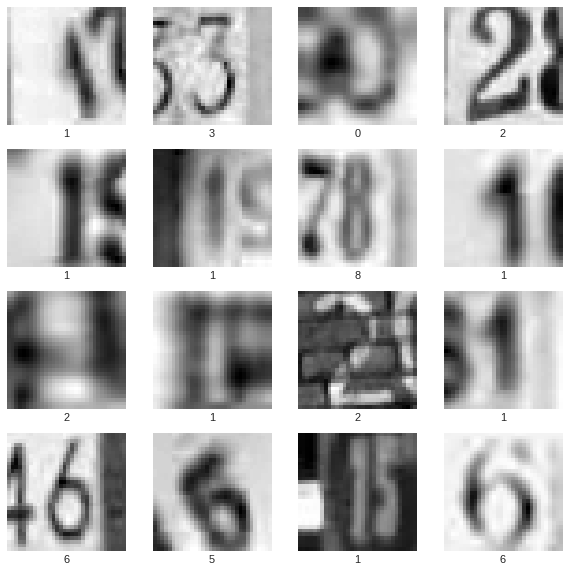

In [0]:
plt.figure(figsize=(10,10))
for i in range(16):
    rnd = np.random.randint(0,X.shape[0])
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if GRAYSCALE:
        plt.imshow(X[rnd][:,:,0],cmap='gray')
    else:
        plt.imshow(X[rnd])
    plt.xlabel((y[rnd]+1)%10) #data treats 10 as 0
plt.show()

## Prepare & Train Model
Model is trained for 20 epochs using TPU. Note that heavy regularization means that occasionally, subsequent epochs will decrease in accuracy.

In [0]:
# consts / params
optimizer = 'adam'
loss='sparse_categorical_crossentropy'
metrics=['accuracy']
EPOCHS = 20

In [0]:
INIT_FILTERS = 24
NUM_FILTERS = INIT_FILTERS
input_img = kr.Input(shape=IMG_DIMS)
OUT_UNITS = 1024
INPUT_DROPOUT = 0.1
HIDDEN_DROPOUT = 0.2
ACT = 'selu' 
NUM_LAYERS = 2
# conv in
x = kr.layers.GaussianNoise(.2)(input_img)
x = kr.layers.Dropout(INPUT_DROPOUT)(x)
x = kr.layers.Conv2D(NUM_FILTERS, 3, padding='same', activation=ACT)(x)
x = kr.layers.Conv2D(NUM_FILTERS, 3, padding='same', activation=ACT)(x)
x = kr.layers.Dropout(HIDDEN_DROPOUT)(x)
x = kr.layers.BatchNormalization()(x)

for n in range(NUM_LAYERS):
  NUM_FILTERS = INIT_FILTERS*(2**n)
  print(NUM_FILTERS)
  tower_1 = kr.layers.Conv2D(NUM_FILTERS, (1, 1), padding='same', activation=ACT)(x)
  tower_1 = kr.layers.Conv2D(NUM_FILTERS, 3, padding='same', activation=ACT)(tower_1)
  tower_1 = kr.layers.BatchNormalization()(tower_1)

  tower_2 = kr.layers.Conv2D(NUM_FILTERS, (1, 1), padding='same', activation=ACT)(x)
  tower_2 = kr.layers.Conv2D(NUM_FILTERS, 3, padding='same', activation=ACT)(tower_2)
  tower_2 = kr.layers.Conv2D(NUM_FILTERS, 3, padding='same', activation=ACT)(tower_2)
  tower_2 = kr.layers.BatchNormalization()(tower_2)

  tower_3 = kr.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
  tower_3 = kr.layers.Conv2D(NUM_FILTERS, (1, 1), padding='same', activation=ACT)(tower_3)
  tower_3 = kr.layers.BatchNormalization()(tower_3)
  x = kr.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
  x = kr.layers.Dropout(HIDDEN_DROPOUT)(x)
  x = kr.layers.MaxPooling2D(padding='same')(x)



#inception final
NUM_FILTERS = NUM_FILTERS*2
tower_1 = kr.layers.Conv2D(NUM_FILTERS, (1, 1), padding='same', activation=ACT)(x)
tower_1 = kr.layers.Conv2D(NUM_FILTERS, 3, padding='same', activation=ACT)(tower_1)
tower_1 = kr.layers.BatchNormalization()(tower_1)

tower_2 = kr.layers.Conv2D(NUM_FILTERS, (1, 1), padding='same', activation=ACT)(x)
tower_2 = kr.layers.Conv2D(NUM_FILTERS, 3, padding='same', activation=ACT)(tower_2)
tower_2 = kr.layers.Conv2D(NUM_FILTERS, 3, padding='same', activation=ACT)(tower_2)
tower_2 = kr.layers.BatchNormalization()(tower_2)


tower_3 = kr.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
tower_3 = kr.layers.Conv2D(NUM_FILTERS, (1, 1), padding='same', activation=ACT)(tower_3)
tower_3 = kr.layers.BatchNormalization()(tower_3)
x = kr.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
x = kr.layers.Dropout(HIDDEN_DROPOUT)(x)
x = kr.layers.GlobalAveragePooling2D()(x)

# out
x = kr.layers.Flatten()(x)
x = kr.layers.Dropout(0.4)(x)
x = kr.layers.Dense(OUT_UNITS, activation=ACT)(x)
predictions = kr.layers.Dense(NUM_CLASSES, activation='softmax')(x)
tiny_ception = kr.Model(inputs=input_img, outputs=predictions)
tiny_ception.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=metrics)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
24
48


In [0]:
if USE_TPU:
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tinycel_tpu = tf.contrib.tpu.keras_to_tpu_model(
      tiny_ception,
      strategy=tf.contrib.tpu.TPUDistributionStrategy(
          tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  tiny_ception = tinycel_tpu
  tiny_ception.summary()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.90.62.106:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7656823687753643564)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16997985513462991626)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14670797564039447619)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:

In [0]:
tf.logging.set_verbosity(0)
tiny_ception_hist = tiny_ception.fit(X,y,epochs=1, validation_data=(X_test,y_test),batch_size = 512) # need to run a single epoch on the full dataset for TPU to compile correctly
tiny_ception_hist = tiny_ception.fit_generator(datagen.flow(X, y, batch_size=512),validation_data=(X_test,y_test), epochs=EPOCHS, steps_per_epoch=X.shape[0])

Train on 73257 samples, validate on 26032 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
73257/73257 [==============================] - 167s 2ms/sample - loss: 1.7751 - acc: 0.3933 - val_loss: 4.8662 - val_acc: 0.1356
Epoch 1/20
144/144 [==============================] - 125s 870ms/step - loss: 1.0972 - acc: 0.6420 - val_loss: 1.0136 - val_acc: 0.6497
Epoch 2/20
144/144 [==============================] - 17s 117ms/step - loss: 0.7134 - acc: 0.7748 - val_loss: 0.4894 - val_acc: 0.8526
Epoch 3/20
144/144 [==============================] - 16s 113ms/step - loss: 0.5948 - acc: 0.8144 - val_loss: 0.3891 - val_acc: 0.8849
Epoch 4/20
144/144 [==============================] - 16s 114ms/step - loss: 0.5165 - acc: 0.8407 - val_loss: 0.4870 - val_acc: 0.8476
Epoch 5/20
144/144 [==============================] - 16s 113ms/step - loss: 0.4762 - acc: 0.8523 - val_loss: 0.3009 - val_acc: 0.9080
Epoch 6/20
144/144 [=============================



## Evaluate Model

In [0]:
def plot_acc(histories, key='acc'):
  plt.figure(figsize=(16,10))
    
  
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
 
def plot_loss(histories, key='loss'):
  plt.figure(figsize=(16,10))
    
  
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

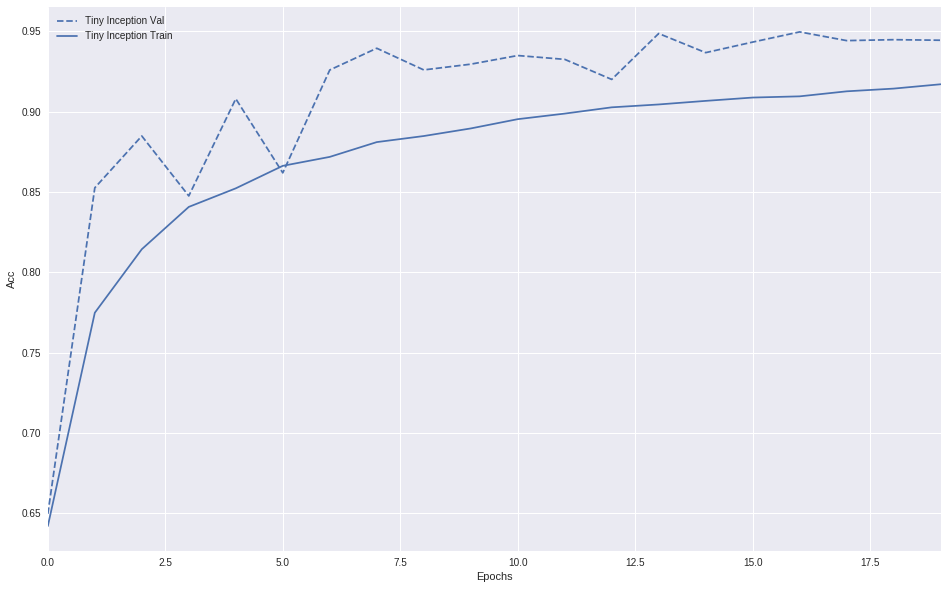

In [0]:
plot_acc([('Tiny Inception', tiny_ception_hist)])

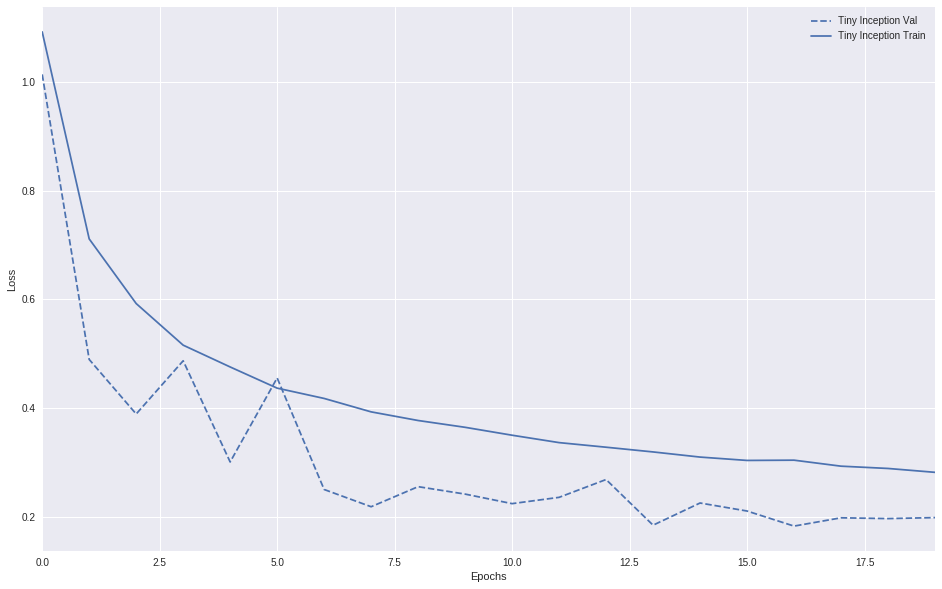

In [0]:
plot_loss([('Tiny Inception', tiny_ception_hist)])

Final trained model evaluation

In [0]:
tiny_ception_acc = tiny_ception.evaluate(X_test, y_test)

26032/26032 [==============================] - 57s 2ms/sample - loss: 0.1986 - acc: 0.9446


In [0]:
print('Tiny inception accuracy:', tiny_ception_acc[1])

Tiny inception accuracy: 0.94464505


## Predictions

In [0]:
tiny_ception_predictions = tiny_ception.predict(X_test)
tiny_ception_classes = tiny_ception_predictions.argmax(axis=-1)

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i][:,:,0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format((predicted_label+1)%10,
                                100*np.max(predictions_array),
                                (true_label+1)%10,
                                color=color))

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

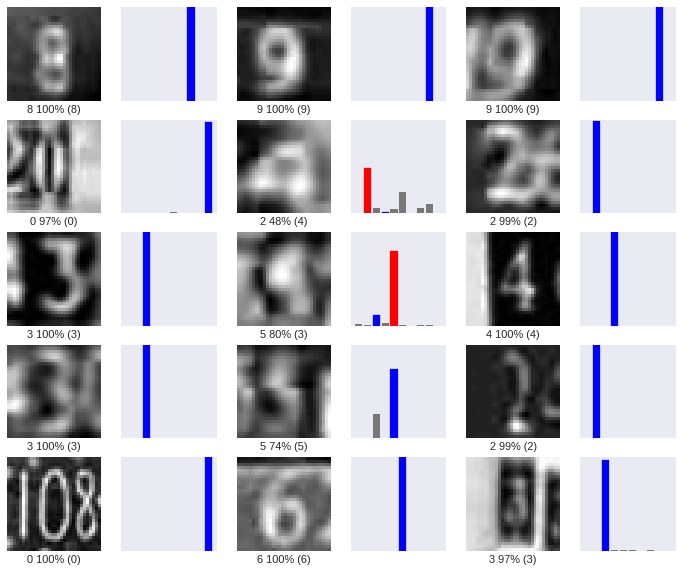

In [0]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  rnd = np.random.randint(0,X_test.shape[0])
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(rnd, tiny_ception_predictions, y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(rnd, tiny_ception_predictions, y_test)
plt.show()

## Save Model

Saves models as h5 files. 

In [0]:
from google.colab import files

In [0]:
tiny_ception.save("/tmp/bishop-graves tinyception.h5")
files.download("/tmp/bishop-graves tinyception.h5")

In [0]:
tiny_ception2 = load_model("/tmp/bishop-graves tinyception.h5")

In [0]:
tiny_ception2_acc = tiny_ception2.evaluate(X_test, y_test)